**Summative Assessment 1.2 - Create a classification algorithm (Logisitc Regression under Decision Tree)**


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/redwinequality/winequality-red.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve



df = pd.read_csv("/kaggle/input/redwinequality/winequality-red.csv")
print(" Data loaded successfully:", df.shape)

# Handle missing values automatically
if df.isnull().values.any():
    print("Missing values detected. Filling with mean...")
    df = df.fillna(df.mean(numeric_only=True))
else:
    print("No missing values detected.")


 Data loaded successfully: (1599, 12)
No missing values detected.


In [3]:
# Ensure no missing values in quality column
if df['quality'].isnull().sum() > 0:
    print("Missing values found in 'quality'. Filling with mean...")
    df['quality'] = df['quality'].fillna(df['quality'].mean())

# Define the classification function
def quality_class(quality):
    if quality <= 4:
        return 'Low'
    elif 5 <= quality <= 6:
        return 'Medium'
    else:
        return 'High'

# Apply and encode
df['Quality_Class'] = df['quality'].apply(quality_class)
label_encoder = LabelEncoder()
df['Quality_Class'] = label_encoder.fit_transform(df['Quality_Class'])

# Split
X = df.drop(columns=['quality', 'Quality_Class'])
y_class_labels = df['Quality_Class']

# Double-check for NaNs before training
print("NaNs in X:", X.isnull().sum().sum())
print("NaNs in y:", pd.isnull(y_class_labels).sum())


NaNs in X: 0
NaNs in y: 0


In [4]:
#2 Split the data into training and testing sets
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class_labels, test_size=0.2, random_state=42
)


# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train_class)

# Make predictions
y_pred_class = dt_classifier.predict(X_test)

# Evaluate the model
print("Decision Tree Classifier - Classification Report:")
print(classification_report(y_test_class, y_pred_class))


Decision Tree Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.60      0.55        47
           1       0.07      0.09      0.08        11
           2       0.89      0.85      0.87       262

    accuracy                           0.78       320
   macro avg       0.49      0.51      0.50       320
weighted avg       0.80      0.78      0.79       320



In [5]:
#3 Split data for regression (predicting the actual quality score)
y_reg = df['quality']  # The continuous target (quality score)

# Split the data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
lr_regressor = LinearRegression()

# Train the model
lr_regressor.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = lr_regressor.predict(X_test_reg)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Linear Regression - Mean Squared Error: {mse:.4f}")


Linear Regression - Mean Squared Error: 0.3900


Expected output =- Decision Tree Classifier - Classification Report:
             precision    recall  f1-score   support

      0       0.81      0.77      0.79       30
      1       0.73      0.77      0.75       31
      2       0.71      0.62      0.66       32

  accuracy                           0.74        93
  macro avg       0.75      0.72      0.73       93
  weighted avg    0.75      0.74      0.74       93


  Linear Regression - Mean Squared Error: 0.3105



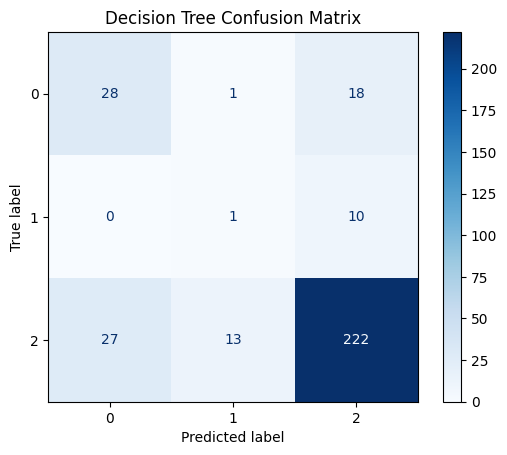

In [6]:
ConfusionMatrixDisplay.from_estimator(dt_classifier, X_test, y_test_class, cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:492: RuntimeWarning: invalid value encountered in divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


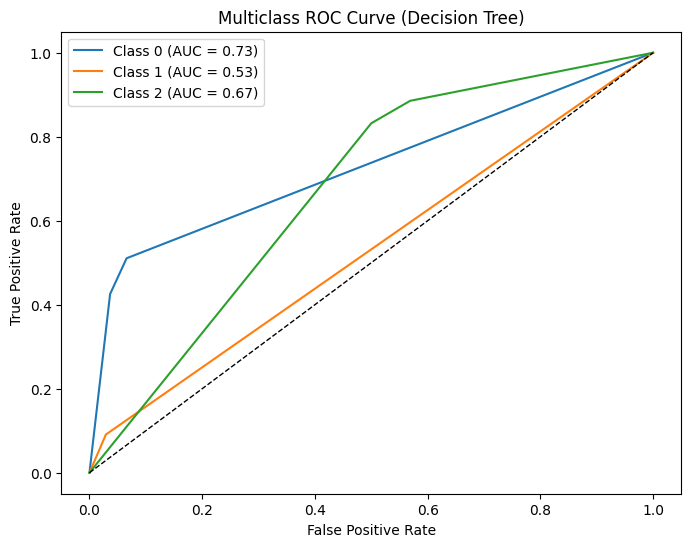

In [7]:
# Re-split (numeric labels)
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X, y_class_labels, test_size=0.2, random_state=42
)

# Ensures no NaNs (Worse)
X_train_vis = X_train_vis.fillna(X_train_vis.mean(numeric_only=True))
X_test_vis = X_test_vis.fillna(X_test_vis.mean(numeric_only=True))

# Classes must match encoded labels
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test_vis, classes=classes)

# Train OVR model
ovr_model = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
y_pred_prob = ovr_model.fit(X_train_vis, y_train_vis).predict_proba(X_test_vis)

# Replace any NaNs from probability normalization
y_pred_prob = np.nan_to_num(y_pred_prob)

# Compute ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i, class_label in enumerate(classes):
    if np.sum(y_test_bin[:, i]) == 0:
        print(f" Skipping class {class_label}: not present in test set")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'Class {class_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Decision Tree)')
plt.legend()
plt.show()


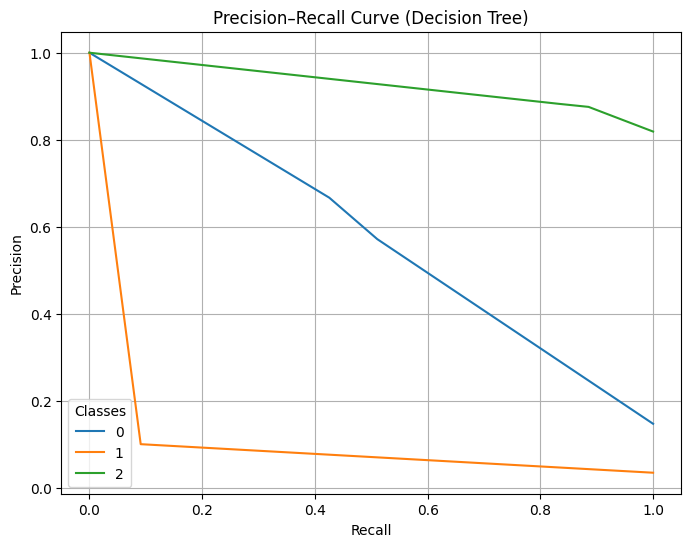

In [8]:
# Precision–Recall Curve (Multiclass)
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    # Skip class if it's missing from test data
    if np.sum(y_test_bin[:, i]) == 0:
        print(f" Skipping class {class_label}: not present in y_test")
        continue

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], np.nan_to_num(y_pred_prob[:, i]))

    # Plot PR curve
    plt.plot(recall, precision, label=f'{class_label}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Decision Tree)')
plt.legend(title="Classes")
plt.grid(True)
plt.show()
